In [2]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

In [3]:
with open("QBdata", 'rb') as picklefile: 
    statsDF = pkl.load(picklefile)

with open("fantasyDEFdata", 'rb') as picklefile: 
    defDF = pkl.load(picklefile)

In [5]:
# reduce DF to QBs that played 4 or more games in the season
QBstats = pd.DataFrame()
for name in statsDF.Name.unique():
    if len(statsDF.loc[statsDF.Name == name]) >= 4:
        if len(QBstats) == 0:
            QBstats = pd.DataFrame(statsDF.loc[statsDF.Name == name])
        else:
            current = pd.DataFrame(statsDF.loc[statsDF.Name == name])
            QBstats = pd.concat([QBstats, current])

QBstats1 = QBstats.sort_values(['Name', 'Week']).reset_index()  
QBstats1.loc[QBstats1.Name == 'Mitch Trubisky'].sort_values(['Week'])

,index,Name,Week,OPP,CMP,ATT,PCT,PassYd,AvgYds/Pass,PassTD,INT,Rating,RushAtt,RushYds,AvgYds/Rush,RushTD,Fantasy Points
449,10,Mitch Trubisky,5,MIN,12,25,48.0,128,5.1,1,1,60.08,3,22,7.3,0,9.32
450,9,Mitch Trubisky,6,BAL,8,16,50.0,113,7.1,1,0,94.01,4,32,8.0,0,9.72
451,14,Mitch Trubisky,7,CAR,4,7,57.1,107,15.3,0,0,101.79,5,3,0.6,0,4.58
452,8,Mitch Trubisky,8,NO,14,32,43.8,164,5.1,0,1,46.88,3,53,17.7,0,9.86
453,2,Mitch Trubisky,10,GB,21,35,60.0,297,8.5,1,0,96.96,0,0,0.0,0,15.88
454,3,Mitch Trubisky,11,DET,18,30,60.0,179,6.0,1,0,88.06,6,53,8.8,0,14.46
455,15,Mitch Trubisky,12,PHI,17,33,51.5,147,4.5,0,2,38.32,4,12,3.0,0,3.08
456,7,Mitch Trubisky,13,SF,12,15,80.0,102,6.8,1,0,117.22,4,19,4.8,0,9.98
457,0,Mitch Trubisky,14,CIN,25,32,78.1,271,8.5,1,0,112.37,2,5,2.5,0,21.34
458,5,Mitch Trubisky,15,DET,31,46,67.4,314,6.8,1,3,66.76,2,3,1.5,0,10.86


In [7]:
# get averages of stats prior to week listed
QBWeeks = QBstats1[['Name', 'Week']]
QBmerge = pd.merge(QBWeeks, QBstats1, on='Name')
QBedit = QBmerge[QBmerge['Week_x'] > QBmerge['Week_y']]
QBedit.rename(columns={'Week_x':'Week'}, inplace = True)
QBavg = QBedit.groupby(['Name','Week']).mean().reset_index()

# take out games 2 and 3 played by QBs (game 1 already removed)
filteredQBdata = pd.DataFrame({})
for name in QBavg.Name.unique():
    current = QBavg.loc[QBavg.Name == name]
    filteredQBdata = pd.concat([filteredQBdata, current.iloc[2:]])
filteredQBdata

/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Name,Week,index,Week_y,CMP,ATT,PCT,PassYd,AvgYds/Pass,PassTD,INT,Rating,RushAtt,RushYds,AvgYds/Rush,RushTD,Fantasy Points
2,Aaron Rodgers,4,5.000000,2.000000,29.666667,44.666667,66.466667,322.333333,7.266667,2.000000,1.000000,93.253333,4.333333,17.333333,4.266667,0.0,19.960000
3,Aaron Rodgers,5,4.500000,2.500000,26.750000,40.000000,67.150000,286.500000,7.175000,2.500000,0.750000,101.950000,3.500000,12.750000,2.950000,0.0,20.735000
4,Aaron Rodgers,6,4.000000,3.000000,25.200000,37.800000,66.820000,273.400000,7.260000,2.600000,0.600000,106.144000,3.600000,16.600000,3.960000,0.0,21.396000
5,Aaron Rodgers,15,6.000000,3.500000,21.333333,32.166667,64.016667,230.833333,6.800000,2.166667,0.500000,98.870000,3.000000,13.833333,3.300000,0.0,17.950000
8,Alex Smith,4,6.333333,2.000000,21.666667,28.000000,77.066667,258.000000,8.966667,2.333333,0.000000,130.163333,3.666667,11.000000,3.433333,0.0,20.753333
9,Alex Smith,5,5.250000,2.500000,23.000000,30.250000,76.050000,266.750000,8.700000,2.000000,0.000000,123.847500,4.500000,22.250000,4.575000,0.0,22.395000
10,Alex Smith,6,4.800000,3.000000,24.200000,31.600000,76.520000,278.200000,8.720000,2.200000,0.000000,125.114000,4.600000,21.600000,4.420000,0.0,23.288000
11,Alex Smith,7,5.500000,3.500000,23.333333,32.000000,73.083333,272.833333,8.466667,2.000000,0.000000,119.028333,4.500000,20.166667,4.216667,0.0,21.930000
12,Alex Smith,8,5.285714,4.000000,23.571429,32.571429,72.557143,282.714286,8.614286,2.142857,0.000000,120.211429,4.000000,17.285714,3.614286,0.0,22.465714
13,Alex Smith,9,6.125000,4.500000,22.375000,32.375000,69.137500,272.625000,8.350000,2.000000,0.000000,114.887500,4.000000,19.250000,4.187500,0.0,21.330000


(15, 30)

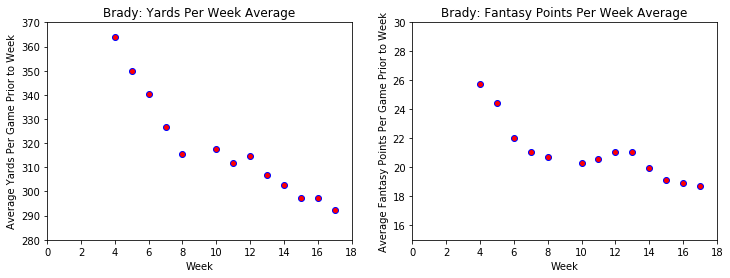

In [8]:
# present graph for MVP - show trend in one player who lowered yards/game and lowered fpts/game
brady = filteredQBdata.loc[filteredQBdata.Name == 'Tom Brady']
fig, (bradyYards, bradyPoints) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

bradyYards.scatter(x=brady['Week'], y=brady['PassYd'], marker='o', c='r', edgecolor='b')
bradyYards.set_title('Brady: Yards Per Week Average')
bradyYards.set_xlabel('Week')
bradyYards.set_ylabel('Average Yards Per Game Prior to Week')
bradyYards.set_xlim(xmin=0, xmax=18)
bradyYards.set_ylim(ymin=280, ymax=370)

bradyPoints.scatter(x=brady['Week'], y=brady['Fantasy Points'], marker='o', c='r', edgecolor='b')
bradyPoints.set_title('Brady: Fantasy Points Per Week Average')
bradyPoints.set_xlabel('Week')
bradyPoints.set_ylabel('Average Fantasy Points Per Game Prior to Week')
bradyPoints.set_xlim(xmin=0, xmax=18)
bradyPoints.set_ylim(ymin=15, ymax=30)

In [9]:
# get avg QB points allowed/week by defense
defWeeks = defDF[['OPP', 'Week']]
defMerge = pd.merge(defWeeks, defDF, on='OPP')
filteredMerge = pd.DataFrame({})
defEdit = defMerge[defMerge['Week_x'] > defMerge['Week_y']]
defEdit.rename(columns = {'Week_x': 'Week'}, inplace=True)
for name in defEdit.Name.unique():
    if name not in filteredQBdata.Name.unique():
        defEdit = defEdit[defEdit.Name != name]
defEdit.drop_duplicates(subset=['OPP', 'Week', 'Week_y'], inplace=True)
defAvg = defEdit.groupby(['OPP', 'Week']).mean().reset_index()
defAvg = defAvg[['OPP', 'Week', 'QB Points Allowed']]


/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [10]:
# merge defense data with QB data
QBtoMerge = QBstats1[['Name', 'Week', 'OPP', 'Fantasy Points']]
df = pd.merge(filteredQBdata, QBtoMerge, on=['Name', 'Week'])
df.drop(['Week_y', 'index', 'Fantasy Points_x', 'RushTD'], axis=1, inplace=True)
df = pd.merge(df, defAvg, on=['OPP', 'Week'])
df.rename(columns={'Fantasy Points_y':'Fantasy Points'}, inplace = True)
df.loc[df.Name == 'Mitch Trubisky']

,Name,Week,CMP,ATT,PCT,PassYd,AvgYds/Pass,PassTD,INT,Rating,RushAtt,RushYds,AvgYds/Rush,OPP,Fantasy Points,QB Points Allowed
360,Mitch Trubisky,8,8.000000,16.000000,51.700000,116.000000,9.166667,0.666667,0.333333,85.293333,4.000000,19.000000,5.300000,NO,9.86,14.312000
361,Mitch Trubisky,10,9.500000,20.000000,49.725000,128.000000,8.150000,0.500000,0.500000,75.690000,3.750000,27.500000,8.400000,GB,15.88,16.072500
362,Mitch Trubisky,11,11.800000,23.000000,51.780000,161.800000,8.220000,0.600000,0.400000,79.944000,3.000000,22.000000,6.720000,DET,14.46,15.144444
363,Mitch Trubisky,12,12.833333,24.166667,53.150000,164.666667,7.850000,0.666667,0.333333,81.296667,3.500000,27.166667,7.066667,PHI,3.08,14.728000
364,Mitch Trubisky,13,13.428571,25.428571,52.914286,162.142857,7.371429,0.571429,0.571429,75.157143,3.571429,25.000000,6.485714,SF,9.98,19.749091
365,Mitch Trubisky,14,13.250000,24.125000,56.300000,154.625000,7.300000,0.625000,0.500000,80.415000,3.625000,24.250000,6.275000,CIN,21.34,15.366667
366,Mitch Trubisky,15,14.555556,25.000000,58.722222,167.555556,7.433333,0.666667,0.444444,83.965556,3.444444,22.111111,5.855556,DET,10.86,16.238462
367,Mitch Trubisky,16,16.200000,27.100000,59.590000,182.200000,7.370000,0.700000,0.700000,82.245000,3.300000,20.200000,5.420000,CLE,18.12,18.861429
368,Mitch Trubisky,17,16.000000,26.727273,59.709091,183.181818,7.463636,0.636364,0.636364,82.747273,3.636364,22.363636,5.500000,MIN,7.32,11.994667


In [139]:
with open("QBfantasyDF", 'wb') as picklefile:
    pkl.dump(df, picklefile)